In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import struct
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def BinToPcd(point_file):
    size_float = 4
    list_pcd = []
    file_to_open = point_file
    file_to_save = str(point_file)[:-3]+"pcd"
    with open(file_to_open, "rb") as f:
        byte = f.read(size_float*4)
        while byte:
            x,y,z,intensity = struct.unpack("ffff", byte)
            list_pcd.append([x,y,z])
            byte = f.read(size_float*4)
    np_pcd = np.asarray(list_pcd)
    pcd = o3d.geometry.PointCloud()
    v3d = o3d.utility.Vector3dVector
    pcd.points = v3d(np_pcd)
    o3d.io.write_point_cloud(file_to_save, pcd)

# Read bin files
point_files = sorted(glob.glob("./../data/2011_09_28/2011_09_28_sync/velodyne_points/data/*.bin"))
image_files = sorted(glob.glob("./../data/2011_09_28/2011_09_28_sync/image_02/data/*.png"))
print(point_files)
print(image_files)

['./../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000000.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000001.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000002.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000003.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000004.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000005.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000006.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000007.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000008.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000009.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000010.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000011.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000012.bin', './../data/

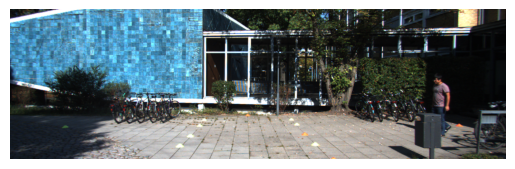

In [3]:
file_index = 1
img = image_files[file_index]
binary = point_files[file_index]

temp_im = cv2.imread(img)
temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2RGB)

plt.imshow(temp_im)
plt.axis('off')
plt.show()


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.9/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/16 06:33:59 - mmengine - WARNING - Failed to search registry with scope "mmseg" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmseg" is a correct scope, or whether the registry is initialized.


Output()

/usr/local/lib/python3.9/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


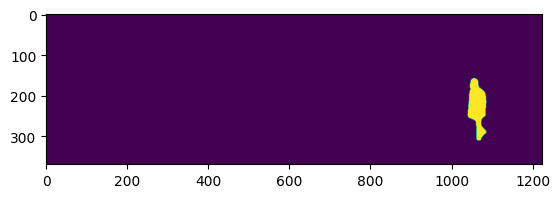

In [4]:
## Semantic segmentation
from segmentations.segmentation import segmentation_img, human_labeling
from argparse import Namespace
import argparse
import json
import os

def load_config_as_args(json_path):
    """Load configuration from a JSON file and return it as an argparse.Namespace object."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Configuration file not found: {json_path}")
    with open(json_path, 'r') as file:
        config = json.load(file)

    # Convert dictionary to Namespace
    args = Namespace(**config)
    # args = parser.parse_args()
    return args

args = load_config_as_args("config.json")
human_mask = segmentation_img(img, args)
plt.imshow(human_mask)
plt.show()
# conversed_mask = mask_conversion(human_mask)
# cv2.imwrite('./temp/temp_mask.jpg',conversed_mask)

In [6]:
## Calibration matrix composition
with open(f'./../data/2011_09_28/calib_cam_to_cam.txt','r') as f:
    calib_cam2cam = f.readlines()
with open(f'./../data/2011_09_28/calib_velo_to_cam.txt','r') as f:
    calib_vel2cam = f.readlines()

P2 = np.array([float(x) for x in calib_cam2cam[25].strip('\n').split(' ')[1:]]).reshape(3, 4)
R2_rect = np.array([float(x) for x in calib_cam2cam[24].strip('\n').split(' ')[1:]]).reshape(3, 3)
R2_rect = np.insert(R2_rect, 3, values=[0, 0, 0], axis=0)
R2_rect = np.insert(R2_rect, 3, values=[0, 0, 0, 1], axis=1)

Tr_vel2cam_R = np.array([float(x) for x in calib_vel2cam[1].strip('\n').split(' ')[1:]]).reshape(3, 3)
Tr_vel2cam_T = np.array([float(x) for x in calib_vel2cam[2].strip('\n').split(' ')[1:]]).reshape(-1, 1)
Tr_vel2cam = np.hstack((Tr_vel2cam_R, Tr_vel2cam_T))
Tr_vel2cam = np.insert(Tr_vel2cam, 3, values=[0, 0, 0, 1], axis=0)

# print('P2 matrix\n',P2)
# print('R2_rect matrix\n',R2_rect)
# print('Tr_vel2cam matrix\n',Tr_vel2cam)

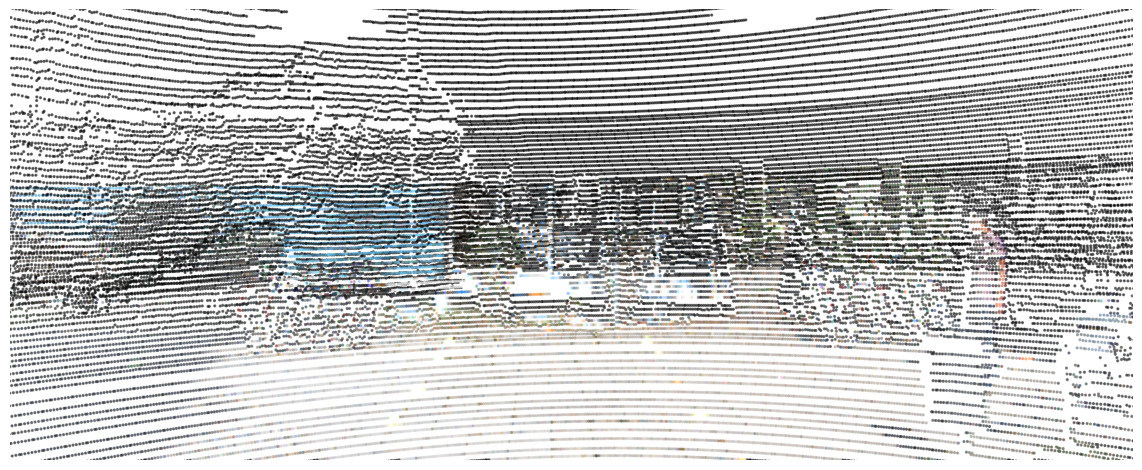

In [32]:
# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]  # lidar xyz (front, left, up)

# TODO: use fov filter?
velo = np.insert(points, 3, 1, axis=1).T
cam = P2.dot(R2_rect.dot(Tr_vel2cam.dot(velo)))
# cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)

# get u,v,z
cam[:2] /= cam[2, :]

# do projection staff
plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
png = mpimg.imread(img)
IMG_H, IMG_W, _ = png.shape

# restrict canvas in range
plt.axis([0, IMG_W, IMG_H, 0])

# plt.imshow(png)
# filter point out of canvas

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
# cam = np.delete(cam, np.where(outlier), axis=1)

# generate color map from depth
u, v, z = cam

# Adding rgb data
rgb_values = []
for u_coord, v_coord, z_coord in zip(u, v, z):
    u_int, v_int = int(round(u_coord)), int(round(v_coord))
    if z_coord >= 0:
        if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
            rgb_value = png[v_int, u_int]
            rgb_values.append(rgb_value)
        else:
            rgb_values.append((0, 0, 0))
    else:
        rgb_values.append((0, 0, 0))

# rgb_values = np.array(rgb_values)/255.

# Create Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(scan[:, :3])
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)
o3d.io.write_point_cloud("./../data/outputs/projected_origin.pcd", point_cloud)

plt.scatter([u], [v],  c=rgb_values, alpha=0.5, s=2)
plt.axis('off')
plt.show()

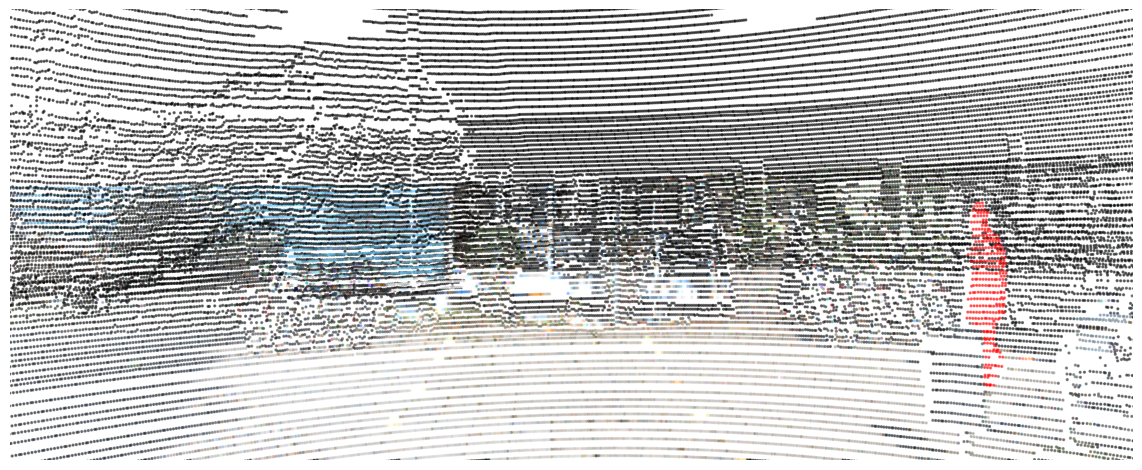

In [33]:
# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]  # lidar xyz (front, left, up)

# TODO: use fov filter?
velo = np.insert(points, 3, 1, axis=1).T
cam = P2.dot(R2_rect.dot(Tr_vel2cam.dot(velo)))
# cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)

# get u,v,z
cam[:2] /= cam[2, :]

# do projection staff
plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
png = human_labeling(temp_im, human_mask)
IMG_H, IMG_W, _ = png.shape

# restrict canvas in range
plt.axis([0, IMG_W, IMG_H, 0])

# plt.imshow(png)
# filter point out of canvas

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
# cam = np.delete(cam, np.where(outlier), axis=1)

# generate color map from depth
u, v, z = cam

# Adding rgb data
rgb_values = []
for u_coord, v_coord, z_coord in zip(u, v, z):
    u_int, v_int = int(round(u_coord)), int(round(v_coord))
    if z_coord >= 0:
        if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
            rgb_value = png[v_int, u_int]
            rgb_values.append(rgb_value)
        else:
            rgb_values.append((0, 0, 0))
    else:
        rgb_values.append((0, 0, 0))

rgb_values = np.array(rgb_values)/255.

# Create Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(scan[:, :3])
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)
o3d.io.write_point_cloud("./../data/outputs/projected_colored.pcd", point_cloud)

plt.scatter([u], [v],  c=rgb_values, alpha=0.5, s=2)
plt.axis('off')
plt.show()

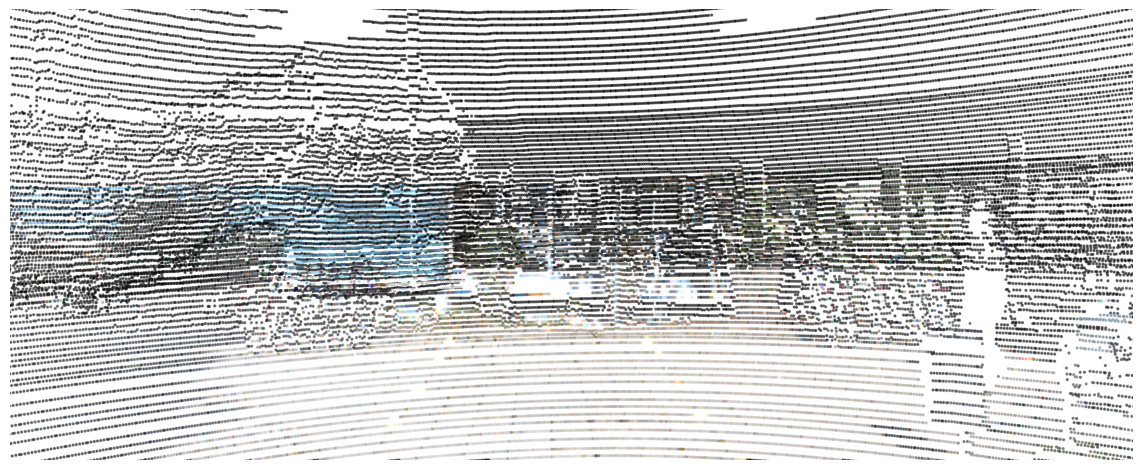

In [54]:
# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]  # lidar xyz (front, left, up)

# TODO: use fov filter?
velo = np.insert(points, 3, 1, axis=1).T
cam = P2.dot(R2_rect.dot(Tr_vel2cam.dot(velo)))
# cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)

# get u,v,z
cam[:2] /= cam[2, :]

# do projection staff
plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
label_color = (255,1,1)
png = human_labeling(temp_im, human_mask, mask_color=label_color)
IMG_H, IMG_W, _ = png.shape

# restrict canvas in range
plt.axis([0, IMG_W, IMG_H, 0])

# plt.imshow(png)
# filter point out of canvas

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
# cam = np.delete(cam, np.where(outlier), axis=1)

# generate color map from depth
u, v, z = cam

# Adding rgb data
rgb_values = []
for u_coord, v_coord, z_coord in zip(u, v, z):
    u_int, v_int = int(round(u_coord)), int(round(v_coord))
    if z_coord >= 0:
        if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
            rgb_value = png[v_int, u_int]
            rgb_values.append(rgb_value)
        else:
            rgb_values.append((0, 0, 0))
    else:
        rgb_values.append((0, 0, 0))

## Erase colored points
erase_idx = []
for idx, rgb in enumerate(rgb_values):
    if np.array_equal(rgb,label_color):
        erase_idx.append(idx)

points = np.delete(points,erase_idx,axis=0)
rgb_values = np.delete(rgb_values, erase_idx,axis=0)
rgb_values = np.array(rgb_values)/255.

# Create Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)
o3d.io.write_point_cloud("./../data/outputs/projected_erased.pcd", point_cloud)

u = np.delete(u, erase_idx)
v = np.delete(v, erase_idx)
plt.scatter([u], [v],  c=rgb_values, alpha=0.5, s=2)
plt.axis('off')
plt.show()

In [52]:
u.shape

(125746,)